**Course:** CSCA 5632 Unsupervised Learning

**Semester:** Summer 2, 2024  

**Student Name:** Yuning Mu

### **1. Project Overview** {-}

#### **Topics and Goals**

   - **Project Topic:** Clustering Analysis of Video Game Sales and Rating Data

   - **Goal:** The main goal is to use clustering techniques to identify patterns and groupings within the video game sales dataset. These clusters will help in understanding factors that contribute to high sales and could be used to develop a recommender system for similar games.




#### **Dataset Description**

  - **Data Source:** The dataset is sourced from a [Kaggle](https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings/data) page, fetched with a web scrape from [Metacritic](https://www.metacritic.com/browse/game/), which includes various features such as game name, platform, release year, genre, publisher, regional sales, global sales, and critic/user scores.

  - **Description:** The dataset contains information about video games across multiple platforms, including their sales performance in different regions, critic and user scores, and other relevant metadata.

  - **Data Characteristics:** The dataset consists of 16719 rows and 16 columns, covering games from various genres and platforms. Features include categorical variables like `Platform`, `Genre`, and `Publisher`, as well as numerical variables like `NA_Sales`, `EU_Sales`, `JP_Sales`, `Global_Sales`, and scores (`Critic_Score`, `User_Score`).

Importing necessary libraries:

In [414]:
import pandas as pd
import numpy as np
from dython.nominal import associations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from textwrap import wrap
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from skopt.space import Integer, Categorical

# set the font of the plot
plt.rcParams['font.family'] = 'sans-serif'

The following code snippet reads the dataset `game_sales.csv` and prints the first few rows to give an overview of the data structure.

The data contains 16,719 rows and 16 columns in total:

In [415]:
data = pd.read_csv('game-data/game_sales.csv')

print("Rows:    ", data.shape[0])
print("Columns: ", data.shape[1])

data.head()

Rows:     16719
Columns:  16


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


### **2. Exploratory Data Analysis (EDA)** {-}

#### EDA

We begin with Exploratory Data Analysis (EDA) to understand the distribution of features, correlations between them, and identify any data cleaning needs.

**Checking for Missing or NaN Values**

First, it's essential check if the dataset contains any missing or NaN values. Missing values can affect the performance of algorithms and might need to be handled appropriately. The following code checks for missing values in each column of the dataset:


In [416]:
missing_values = data.isnull().sum()

print("Are there missing values in any column?")
if missing_values.any():
    print("The following columns have missing values:")
    for column, value in missing_values[missing_values > 0].items():
        print(f"- {column}: {value} missing value(s)")
else:
    print("No missing values found")

Are there missing values in any column?
The following columns have missing values:
- Name: 2 missing value(s)
- Year_of_Release: 269 missing value(s)
- Genre: 2 missing value(s)
- Publisher: 54 missing value(s)
- Critic_Score: 8582 missing value(s)
- Critic_Count: 8582 missing value(s)
- User_Score: 6704 missing value(s)
- User_Count: 9129 missing value(s)
- Developer: 6623 missing value(s)
- Rating: 6769 missing value(s)


Also, though most values in the User_Score column are numeric, there are some 'tbd' values:

In [417]:
tbd_count = data['User_Score'].eq('tbd').sum()
print(f"Number of rows with 'tbd' in User_Score: {tbd_count}")

Number of rows with 'tbd' in User_Score: 2425


**Initial Data Cleaning and Duplicate Checking**

To standarize the dataset, we first clean all the data with missing values.

After dropping all NaN values, the `User_Score` column contains no values with 'tbd', possibly because the 'tbd' values were always associated with NaN values:

In [418]:
data = data.dropna()
tbd_count = data['User_Score'].eq('tbd').sum()
print(f"Number of rows with 'tbd' in User_Score after dropping NA: {tbd_count}")

# check number of rows after dropping missing values
print("Rows:    ", data.shape[0])
print("Columns: ", data.shape[1])


Number of rows with 'tbd' in User_Score after dropping NA: 0
Rows:     6825
Columns:  16




Next, we check for duplicate rows in the dataset. Duplicates can cause bias in the analysis and need to be addressed. The code checks for the number of duplicate rows, and if any are found, it removes them and provides the count of rows before and after the removal.

In [419]:
duplicates = data.duplicated().sum()
print(f"\nNumber of duplicate rows in the dataset: {duplicates}")

if duplicates > 0:
    data_cleaned = data.drop_duplicates()
    print(f"Number of rows after removing duplicates: {data_cleaned.shape[0]}")
else:
    print("No duplicates found.")


Number of duplicate rows in the dataset: 0
No duplicates found.


**Feature Distribution Analysis**

Understanding the distribution of each feature is crucial in data analysis, as it helps to identify patterns, outliers, and the overall spread of the data. In this section, we will plot the distribution of each feature in the dataset. For numerical features, we will use histograms, and for categorical features, we will use bar plots.


In [420]:
def plot_feature_distribution(data):
    num_features = len(data.columns)

    fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(10, 4 * num_features))
    axes = axes.flatten()

    for i, column in enumerate(data.columns):
        
        if data[column].dtype not in ['int64', 'float64'] or column == 'Year_of_Release':
            sns.countplot(x=data[column], ax=axes[i],  palette='viridis', legend=False, hue=data[column])
        else:
            sns.histplot(data[column], kde=True, ax=axes[i], color='skyblue', element='step')

        
        axes[i].set_ylabel('Count')
        axes[i].set_title(f"Distribution of {column}")
    
    # for j in range(i + 1, len(axes)):
    #     fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()
    

In [421]:
numerical_data = data.select_dtypes(include=['int64', 'float64'])
print("Numerical columns:")
print(numerical_data.columns)

categorical_data = data.select_dtypes(exclude=['int64', 'float64'])
print("\nCategorical columns:")
print(categorical_data.columns)


Numerical columns:
Index(['Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales',
       'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Count'],
      dtype='object')

Categorical columns:
Index(['Name', 'Platform', 'Genre', 'Publisher', 'User_Score', 'Developer',
       'Rating'],
      dtype='object')


The numerical features include:
- `Year_of_Release`: The year the game was released.
- `NA_Sales`, `EU_Sales`, `JP_Sales`, `Other_Sales`: Sales in North America, Europe, Japan and other regions respectively.
- `Global_Sales`: Total sales worldwide.
- `Critic_Score`, `Critic_Count`: Aggregate score compiled by Metacritic staff and the number of critics used in coming up with the score.
- `User_Score`, `User_Count`: Score based on Metacritic user reviews and the number of users who reviewed the game.

And the categorical features include:
- `Name`: Name of the game
- `Platform`: Platform on which the game was released
- `Genre`: Genre of the game
- `Publisher`: Publisher of the game
- `Developer`: Developer of the game
- `Rating`: ESRB ratings for the games. This is a categorical column with values: `E`, `E10+`, `M`, `T`, `RP`, `K-A`, `AO`.


Note that the `Year_of_Release` column is of numerical type. However, it should be treated as a categorical column.

Also, the `User_Score` column is considered as an object type because the previous data contains the string 'tbd' which stands for 'to be determined'. We will handle this by converting the column to a float type.

In [422]:
data['Year_of_Release'] = data['Year_of_Release'].astype('int64').astype('str')

data['User_Score'] = pd.to_numeric(data['User_Score'], errors='coerce')

print(data.dtypes)

Name                object
Platform            object
Year_of_Release     object
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score         float64
User_Count         float64
Developer           object
Rating              object
dtype: object


Below is the critic score and user score distribution.

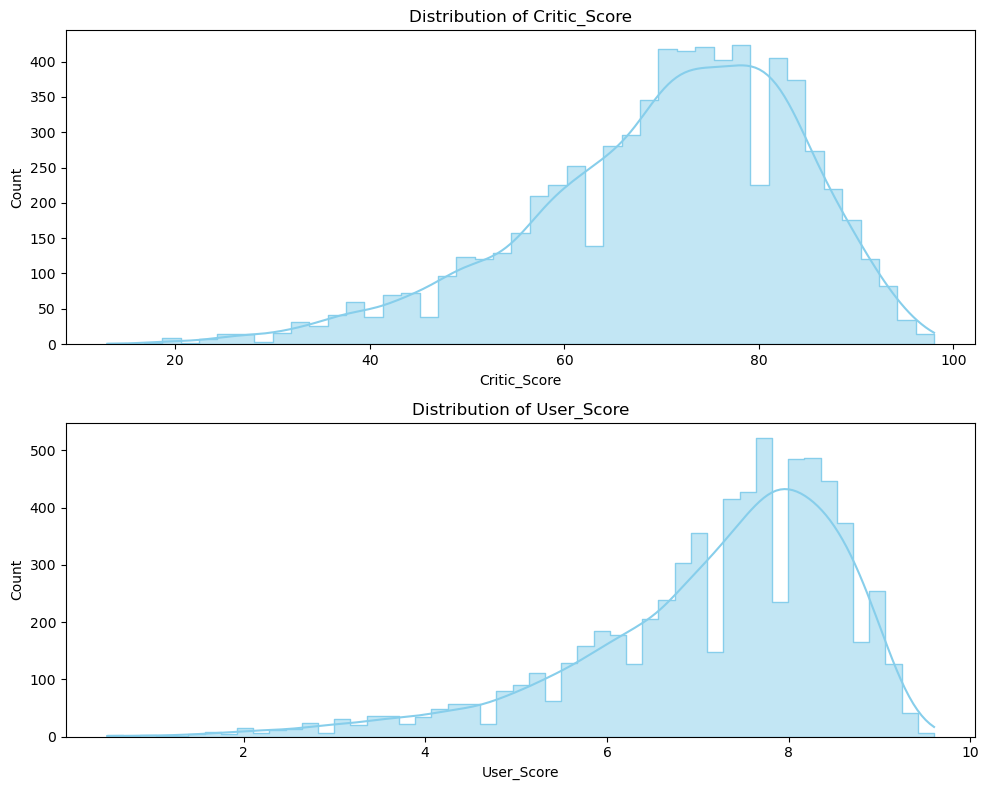

In [423]:
# display the distribution of critic_score and user_score
selected_numerical_data = data[['Critic_Score', 'User_Score']]
plot_feature_distribution(selected_numerical_data)

Below is the year, genre, platform and rating distribution of the data.

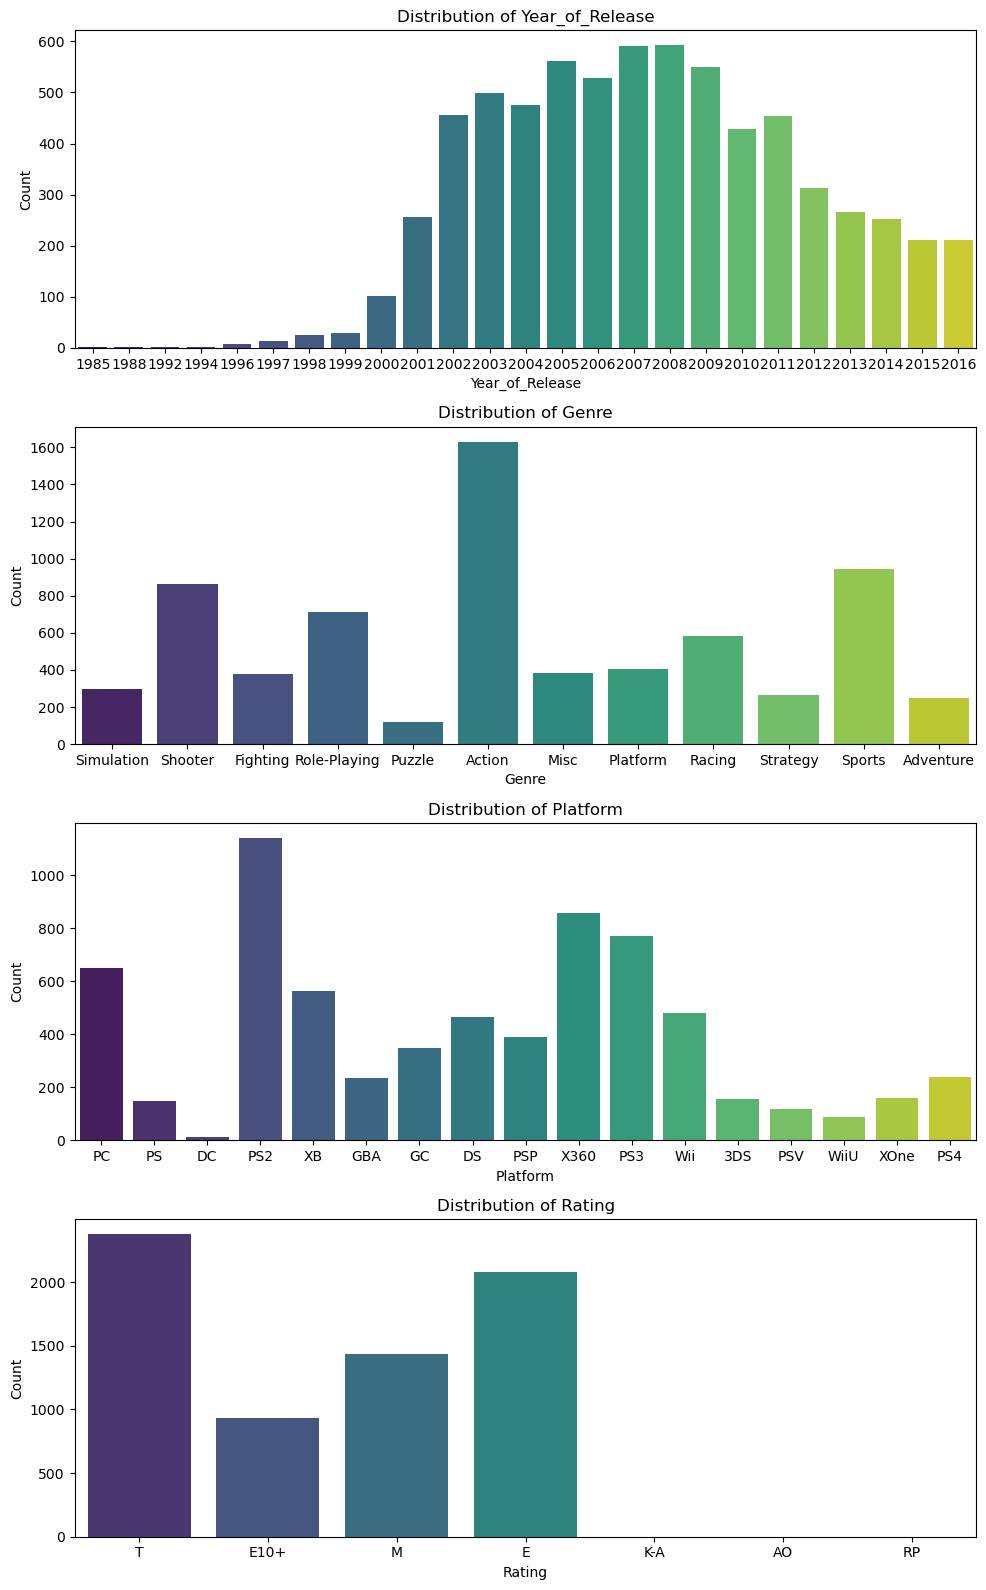

In [424]:
# display the distribution of year, genre, platform and rating
data_sorted = data.sort_values(by='Year_of_Release')
selected_categorical_data = data_sorted[['Year_of_Release', 'Genre', 'Platform', 'Rating']]
plot_feature_distribution(selected_categorical_data)

**Correlation Analysis**

To understand the relationships between different features, we will create a correlation matrix and visualize it using a heatmap.

We need to accomodate the nominal features, i.e., the features that cannot be ranked or quantified. We will use the `identify_nominal_columns` from the dython module to do this.

In [425]:
from dython.nominal import identify_nominal_columns
categorical_features = identify_nominal_columns(data)

print("Categorical features:")
features = ', '.join(categorical_features)
print("\n".join(wrap(features, 40)))

Categorical features:
Name, Platform, Year_of_Release, Genre,
Publisher, Developer, Rating


Now we can include these features and display a full correalation matrix for all features:

In [426]:
%%capture
complete_correlation = associations(data, figsize=(10,10));

In [427]:
df_complete_corr = complete_correlation['corr']
df_complete_corr.to_csv('analysis/complete_correlation_matrix.csv')


df_complete_corr.style.background_gradient(
    cmap='YlGnBu', axis=None
).format(
    precision=2
).set_properties(**{'max-width': '30px', 'font-size': '10pt', 'text-align': 'center'})

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
Name,1.00,0.15,0.55,0.60,0.57,0.93,0.92,0.98,0.83,0.94,0.97,0.87,0.93,0.90,0.57,0.38
Platform,0.15,1.00,0.37,0.15,0.25,0.18,0.16,0.21,0.18,0.16,0.22,0.40,0.27,0.35,0.29,0.18
Year_of_Release,0.55,0.37,1.00,0.08,0.35,0.09,0.10,0.16,0.08,0.10,0.17,0.28,0.29,0.27,0.28,0.20
Genre,0.60,0.15,0.08,1.00,0.31,0.11,0.09,0.16,0.08,0.09,0.17,0.23,0.13,0.21,0.59,0.31
Publisher,0.57,0.25,0.35,0.31,1.00,0.29,0.25,0.46,0.21,0.30,0.41,0.41,0.33,0.30,0.60,0.21
NA_Sales,0.93,0.18,0.09,0.11,0.29,1.00,0.84,0.47,0.73,0.96,0.23,0.28,0.09,0.25,0.57,0.10
EU_Sales,0.92,0.16,0.10,0.09,0.25,0.84,1.00,0.52,0.72,0.94,0.21,0.27,0.06,0.28,0.54,0.10
JP_Sales,0.98,0.21,0.16,0.16,0.46,0.47,0.52,1.00,0.39,0.61,0.15,0.17,0.13,0.07,0.65,0.09
Other_Sales,0.83,0.18,0.08,0.08,0.21,0.73,0.72,0.39,1.00,0.80,0.19,0.24,0.06,0.24,0.51,0.09
Global_Sales,0.94,0.16,0.10,0.09,0.30,0.96,0.94,0.61,0.80,1.00,0.24,0.29,0.09,0.26,0.58,0.10


**Observations on the Overall Correlation Matrix**

The `Name` feature shows high correlations with almost all other features, which is not typically meaningful in a traditional sense. This high correlation likely arises because `Name` is a unique identifier for each game and might incidentally correlate with features due to the inherent structure of the dataset. In practice, `Name` might not be used for predictive modeling or analysis, as it is more of a categorical label than a feature with explanatory power.

- **Sales:**

  - **NA_Sales, EU_Sales, JP_Sales, and Global_Sales:** Strong correlations exist between regional sales (NA, EU, JP) and Global_Sales, especially with NA_Sales (0.96) and EU_Sales (0.94). This indicates that NA and EU are significant contributors to overall sales. `JP_Sales` shows a slightly lower correlation with Global_Sales (0.61), which may indicate regional preferences and differences in game publishing strategies specific to the Japanese market.
  

- **Critic and User Scores:**

  - **Critic_Score and Developer (0.74), User_Score (0.58), Global_Sales (0.24):** Critic_Score shows a strong relationship with Developer quality and User_Score, and a moderate correlation with Global_Sales.
 
  - **User_Score and Developer (0.64):** User_Score correlates well with Developer, showing user appreciation is tied to developer reputation.

- **Developer and Platform:**

  - **Developer and Platform (0.29), Genre (0.59):** Developer shows moderate correlations with Platform and Genre, indicating certain developers specialize in specific genres or platforms.

- **Miscellaneous:**

  - **Year_of_Release and Critic_Count (0.28):** Newer games tend to have more critic reviews, as shown by the moderate correlation between Year_of_Release and Critic_Count.


**Other Comparisons across Categories**

- *Sales over Time*
- *Year of Release vs. Genre*
- *Platform vs. Global Sales*
- *Top 15 Developers and Publishers by Game Count*
- *Top 15 Developers and Publishers by Average Critic Score*
- *Top 15 Developers and Publishers by Global Sales*
- *Popularity of Genres Sorted by Global Sales*

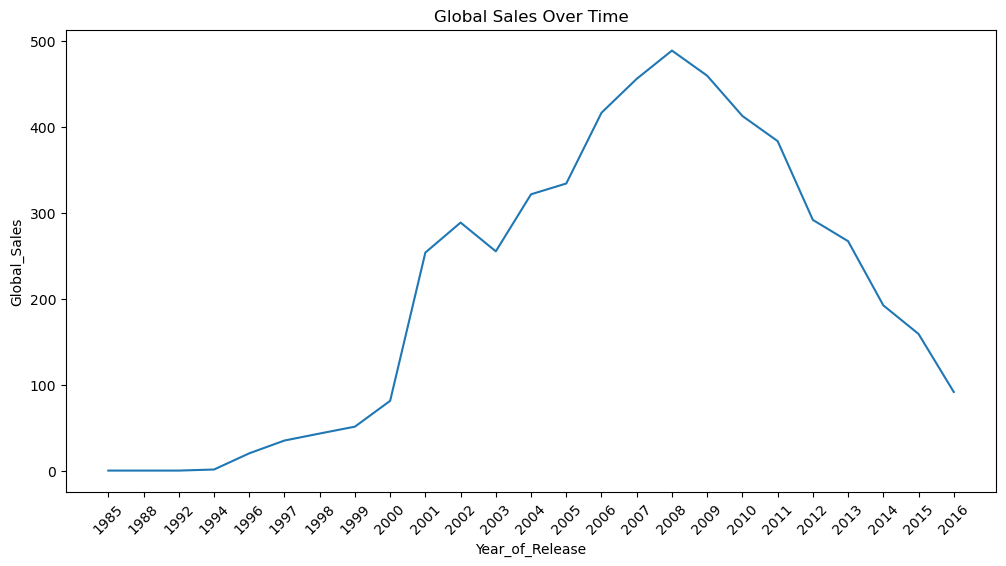

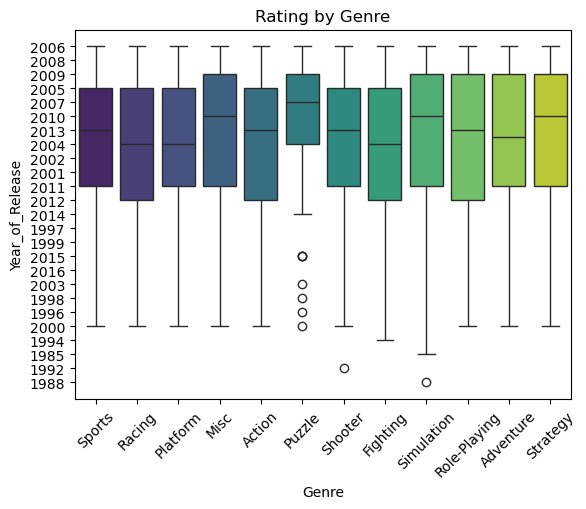

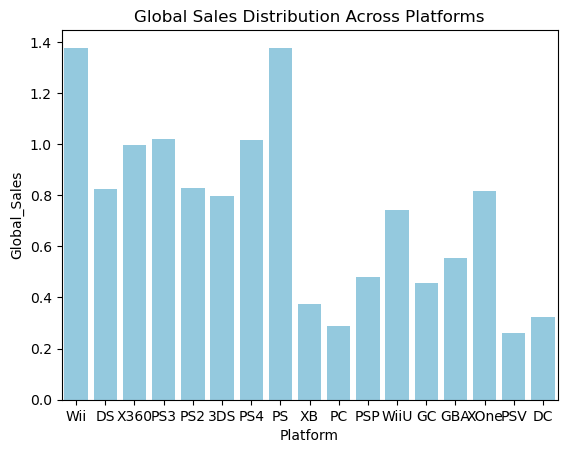

In [428]:
# sales over time
sales_by_year = data.groupby('Year_of_Release').sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year_of_Release', y='Global_Sales', data=sales_by_year)
plt.title('Global Sales Over Time')
plt.xticks(rotation=45)
plt.show()

# year of release vs genre
sns.boxplot(x='Genre', y='Year_of_Release', data=data, palette='viridis', hue='Genre')
plt.title(f'{column} by Genre')
plt.xticks(rotation=45)
plt.show()

# platform vs global sales
sns.barplot(x='Platform', y='Global_Sales', data=data, errorbar=None, color='skyblue')
plt.title('Global Sales Distribution Across Platforms')
plt.show()


Below is the number of game released, average critic score and sales of top developers/publishers:

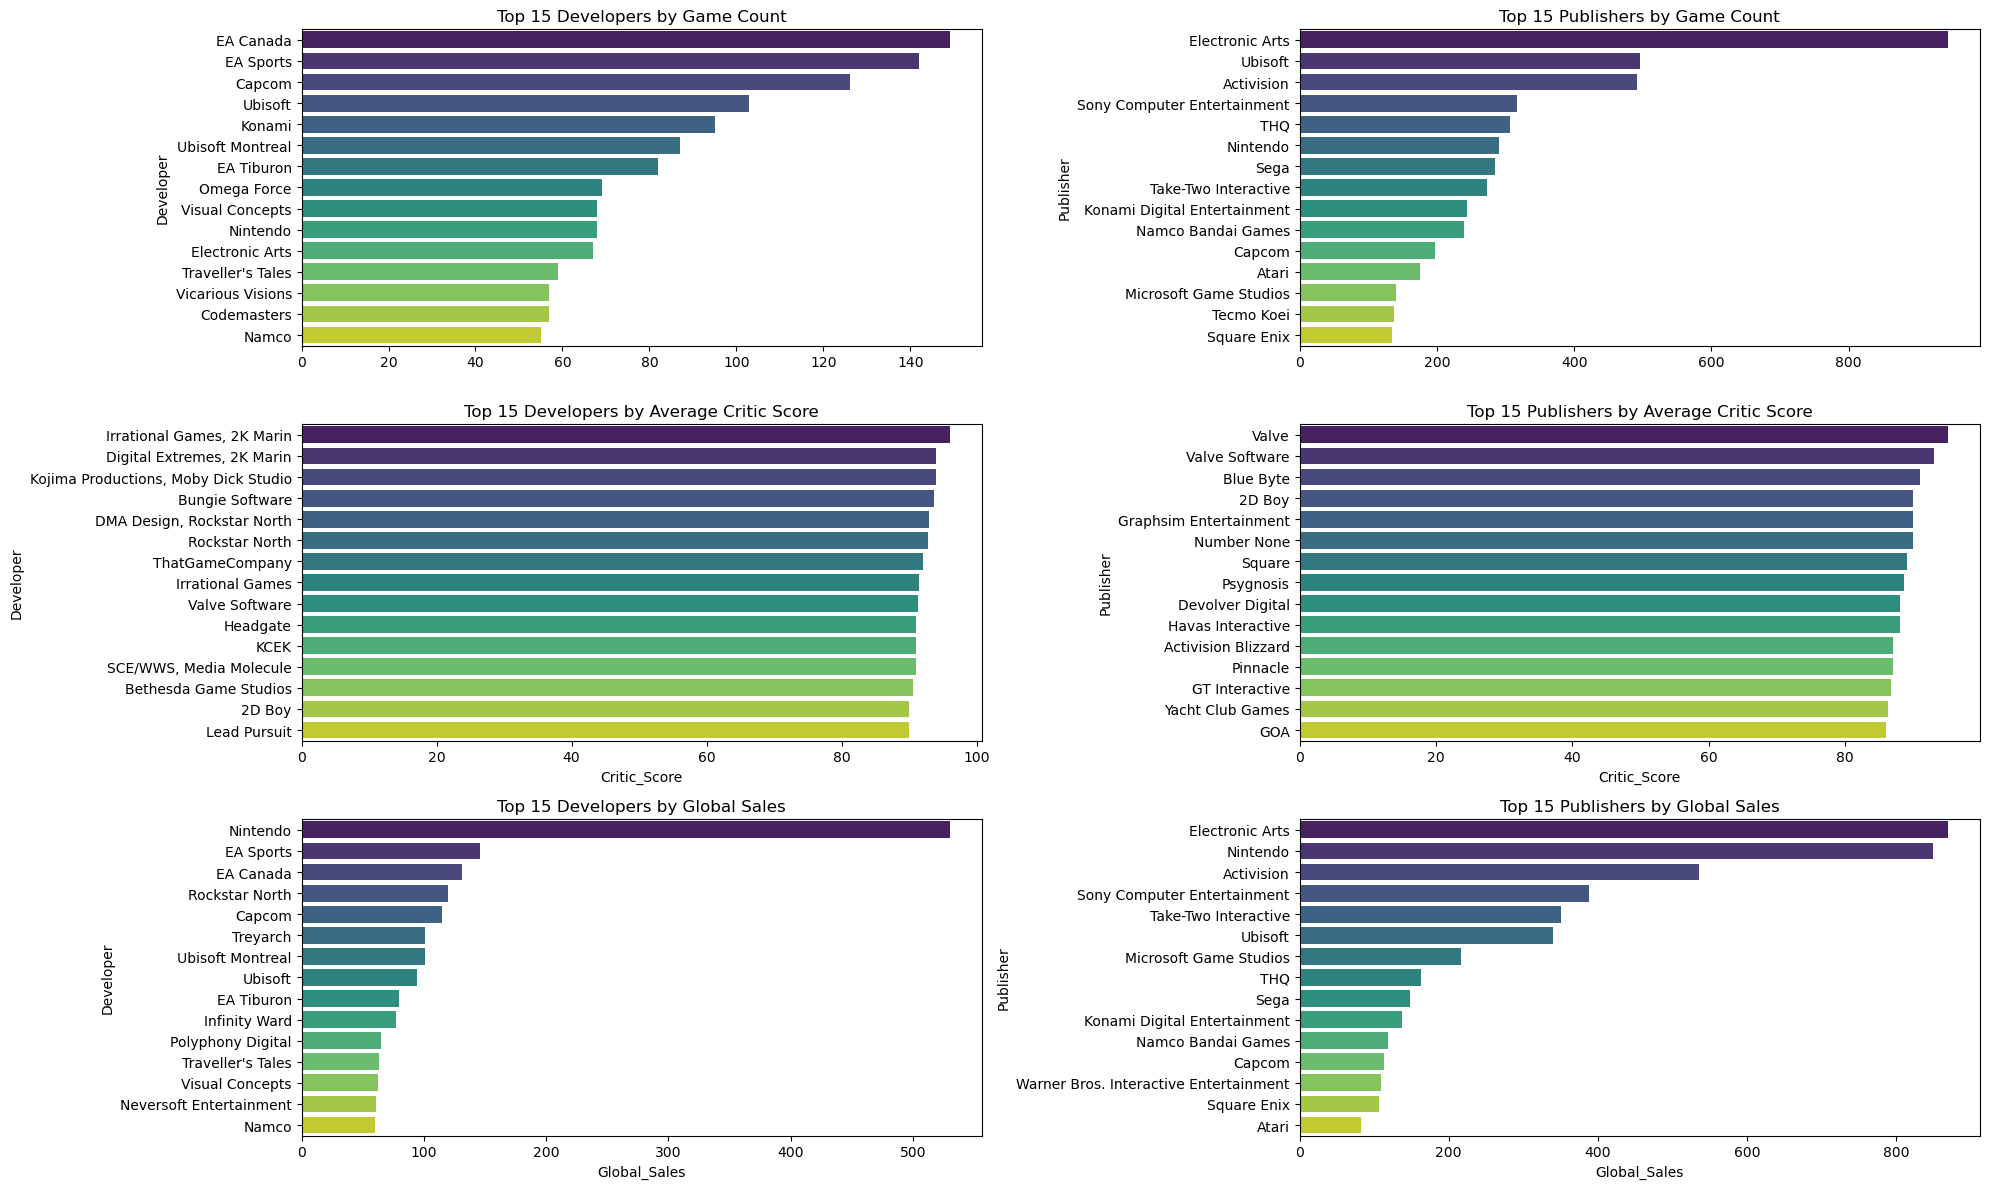

In [429]:
fig, axs = plt.subplots(3, 2, figsize=(20, 12))

# Top 15 Developers and Publishers by Game Count
top_15_developers = data['Developer'].value_counts().nlargest(15)
sns.barplot(x=top_15_developers.values, y=top_15_developers.index, palette='viridis', ax=axs[0, 0], hue=top_15_developers.index)
axs[0, 0].set_title('Top 15 Developers by Game Count')

top_15_publishers = data['Publisher'].value_counts().nlargest(15)
sns.barplot(x=top_15_publishers.values, y=top_15_publishers.index, palette='viridis', ax=axs[0, 1], hue=top_15_publishers.index)
axs[0, 1].set_title('Top 15 Publishers by Game Count')

# Top 15 Developers and Publishers by Average Critic Score
top_15_developers_score = data.groupby('Developer')['Critic_Score'].mean().nlargest(15).reset_index()
sns.barplot(x='Critic_Score', y='Developer', data=top_15_developers_score, palette='viridis', ax=axs[1, 0], hue='Developer')
axs[1, 0].set_title('Top 15 Developers by Average Critic Score')

top_15_publishers_score = data.groupby('Publisher')['Critic_Score'].mean().nlargest(15).reset_index()
sns.barplot(x='Critic_Score', y='Publisher', data=top_15_publishers_score, palette='viridis', ax=axs[1, 1], hue='Publisher')
axs[1, 1].set_title('Top 15 Publishers by Average Critic Score')

# Top 15 Developers and Publishers by Global Sales
top_15_developers_sales = data.groupby('Developer')['Global_Sales'].sum().nlargest(15).reset_index()
sns.barplot(x='Global_Sales', y='Developer', data=top_15_developers_sales, palette='viridis', ax=axs[2, 0], hue='Developer')
axs[2, 0].set_title('Top 15 Developers by Global Sales')

top_15_publishers_sales = data.groupby('Publisher')['Global_Sales'].sum().nlargest(15).reset_index()
sns.barplot(x='Global_Sales', y='Publisher', data=top_15_publishers_sales, palette='viridis', ax=axs[2, 1], hue='Publisher')
axs[2, 1].set_title('Top 15 Publishers by Global Sales')

plt.tight_layout()
plt.show()

Below is the popularity of the genres based on the global sales:

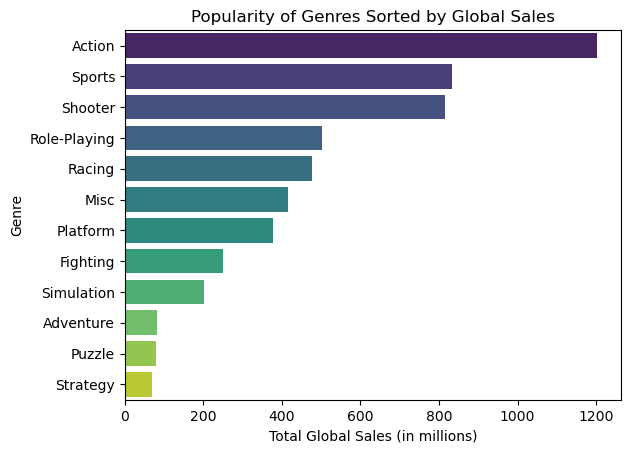

In [430]:
# Most popular genres by global sales
genre_sales = data.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False).reset_index()
sns.barplot(x='Global_Sales', y='Genre', data=genre_sales, palette='viridis', hue='Genre')
plt.title('Popularity of Genres Sorted by Global Sales')
plt.xlabel('Total Global Sales (in millions)')
plt.ylabel('Genre')
plt.show()

**Word Cloud for Game Titles**

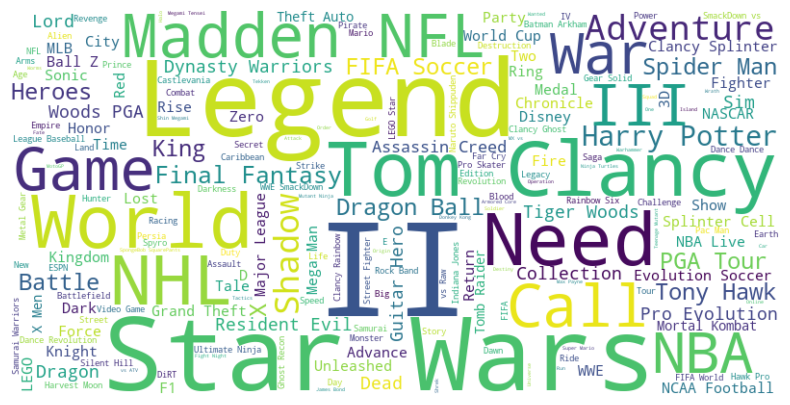

In [431]:
from wordcloud import WordCloud

text = " ".join(title for title in data['Name'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


We can observe that certain words with high frequencies are commonly used in game titles, such as `Adventure`, `Legend` and `War.` Additionally, there are frequent mentions of well-known franchises like `Tom Clancy,` `NBA,` `Final Fantasy,` and `Star Wars.`

**Platform vs Genre**

The following visualization illustrates the distribution of different game genres across various platforms. We use a scatter plot where the size of each point corresponds to the frequency of a particular genre on a specific platform.


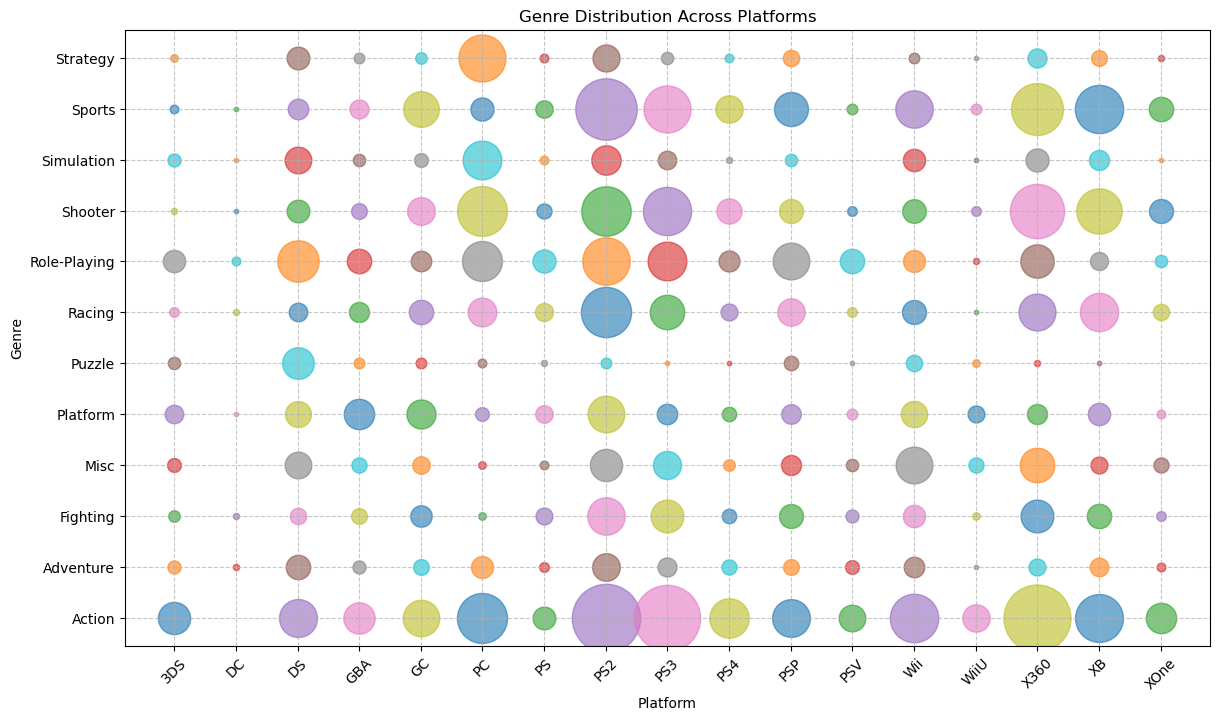

In [432]:
genre_platform_counts = pd.crosstab(data['Platform'], data['Genre'])

plt.figure(figsize=(14, 8))

for i, platform in enumerate(genre_platform_counts.index):
    for j, genre in enumerate(genre_platform_counts.columns):
        plt.scatter(platform, genre, s=genre_platform_counts.loc[platform, genre] * 10, alpha=0.6)

plt.title('Genre Distribution Across Platforms')
plt.xlabel('Platform')
plt.ylabel('Genre')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()


**Distribution of Critic Score vs User Score**

The plot below shows the relationship between Critic Scores and User Scores using a scatter plot with a regression line. This visualization helps us understand how closely critic reviews align with user reviews in the dataset.


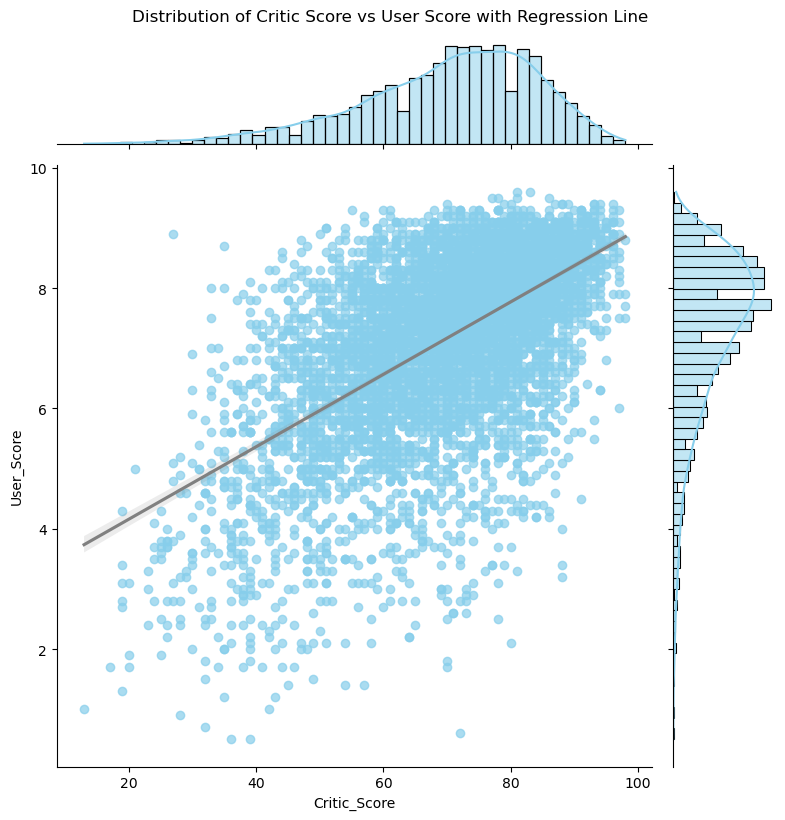

In [433]:

sns.jointplot(
    x='Critic_Score', y='User_Score', data=data,
    kind='reg', color='skyblue',
    height=8, scatter_kws={'alpha':0.7}, line_kws={'color':'gray'}
)
plt.suptitle('Distribution of Critic Score vs User Score with Regression Line', y=1.02)
plt.show()

**Categorizing release years**

Given the correlations previously provided, to enhance our analysis, we perform feature engineering by categorizing the release year into decades and combining regional sales data. These steps help to simplify the dataset and create more meaningful features for clustering and other analyses.


In [434]:
def categorize_year(year):
    year = int(year)
    if year < 1990:
        return 'Before 1990'
    elif 1990 <= year < 2000:
        return '1990s'
    elif 2000 <= year < 2010:
        return '2000s'
    elif 2010 <= year < 2020:
        return '2010s'
    else:
        return '2020s'

# Apply the function to create a new column for decade
data_cleaned = data.copy()
data_cleaned['Year_Category'] = data['Year_of_Release'].apply(categorize_year)
data_cleaned = data_cleaned.assign(NA_EU_Sales=data[['NA_Sales', 'EU_Sales']].sum(axis=1))


features_kept = [
    'Global_Sales', 'NA_EU_Sales',
    'JP_Sales', 'Critic_Score', 'User_Score', 
    'Year_Category', 'Genre'
]


**Scaling and Encoding Features**

To prepare the dataset for clustering analysis, we need to standardize the numerical features and encode the categorical features. This preprocessing step ensures that the data is in the right format for effective machine learning.

In [435]:
# Re-run the preprocessor with the updated feature set
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Critic_Score', 'Global_Sales', 'User_Score', 'NA_EU_Sales', 'JP_Sales']),
        ('cat', OneHotEncoder(drop='first'), ['Genre', 'Year_Category'])
    ])


data_transformed = preprocessor.fit_transform(data_cleaned[features_kept])

### 3. Clustering Analysis {-}

To identify the optimal number of clusters (`k`) for K-Means clustering, we use two key metrics: **Inertia** and **Silhouette Score**. The following code calculates these metrics for a range of `k` values and visualizes the results.


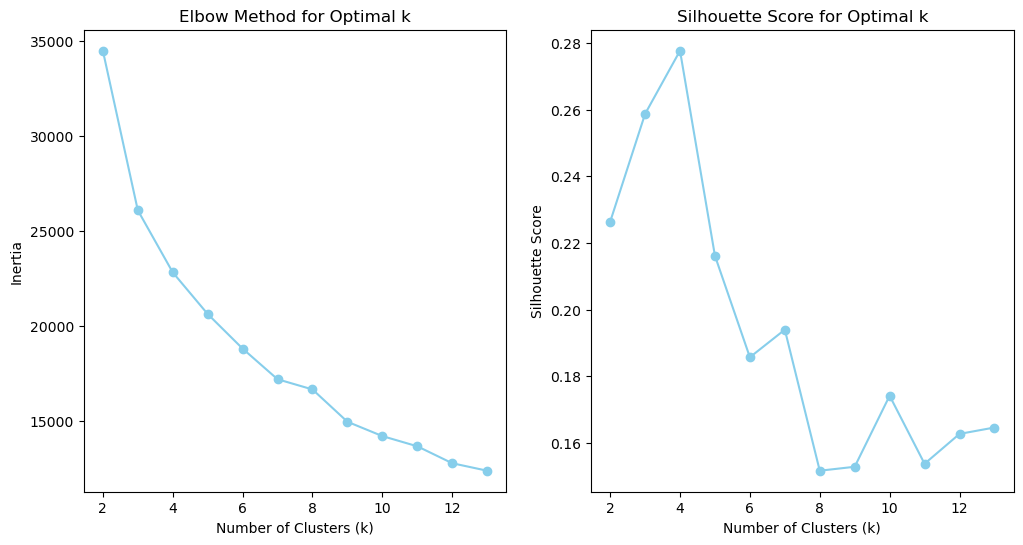

In [436]:
inertia = []
silhouette_scores = []
k_range = range(2, 14)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_transformed)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_transformed, kmeans.labels_))


def plot_inertia_silhouette(inertia, silhouette_scores, k_range):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertia, 'o-', color='skyblue')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')

    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouette_scores, 'o-', color='skyblue')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Optimal k')

    plt.show()


plot_inertia_silhouette(inertia, silhouette_scores, k_range)

**Visualizing Clusters with PCA**

To better understand and visualize the clusters formed by the K-Means algorithm, we use Principal Component Analysis (PCA) to reduce the dimensionality of the dataset to two dimensions. This allows us to create a 2D scatter plot that represents the clusters.

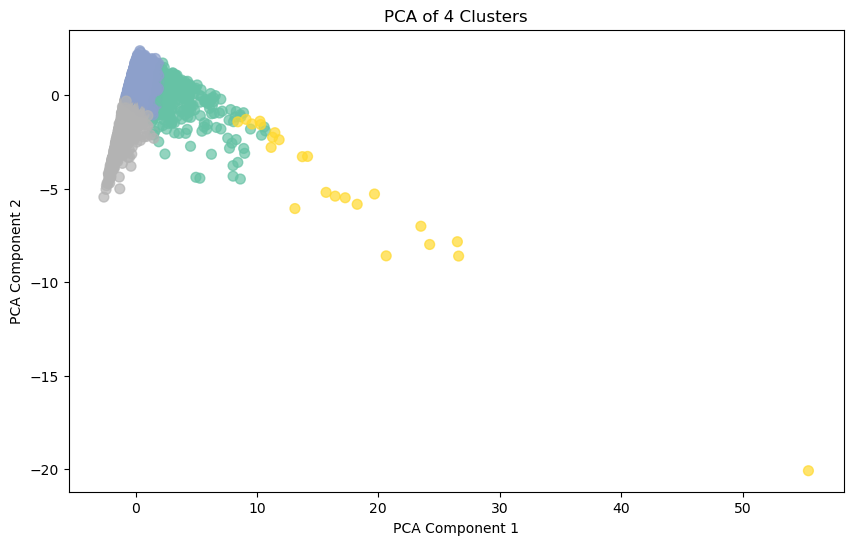

In [437]:
def plot_PCA_clusters(data, kmeans_labels, k):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)

    plt.figure(figsize=(10, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_labels, cmap='Set2', s=50, alpha=0.7)
    plt.title(f'PCA of {k} Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(data_transformed)

data['Cluster'] = kmeans_labels
plot_PCA_clusters(data_transformed, kmeans_labels, optimal_k)

### **4. Bayesian Optimization for K-Means Clustering** {-}

To fine-tune the hyperparameters of the K-Means clustering algorithm, we use Bayesian Optimization. This method systematically searches the parameter space to find the best combination of hyperparameters that maximize the clustering quality, measured by the Silhouette Score.


In [438]:
X = data_cleaned[features_kept]

X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

search_space = {
    'n_clusters': Integer(4, 10),
    'init': Categorical(['k-means++', 'random']),
    'n_init': Integer(10, 50),
    'max_iter': Integer(100, 500)
}

kmeans = KMeans(random_state=42)

def custom_silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    return silhouette_score(X, cluster_labels, metric='euclidean')

bayes_search = BayesSearchCV(
    estimator=kmeans,
    search_spaces=search_space,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    scoring=custom_silhouette_scorer,
    random_state=42
)

bayes_search.fit(X_train_transformed)
best_kmeans = bayes_search.best_estimator_
y_pred = best_kmeans.fit_predict(data_transformed)


data_with_clusters = data_cleaned[features_kept].copy()
data_with_clusters['Cluster'] = y_pred

Best Parameters for K-Means:
Number of Clusters: 4 
Initialization Method: random 
Number of Initializations: 49 
Maximum Number of Iterations: 115


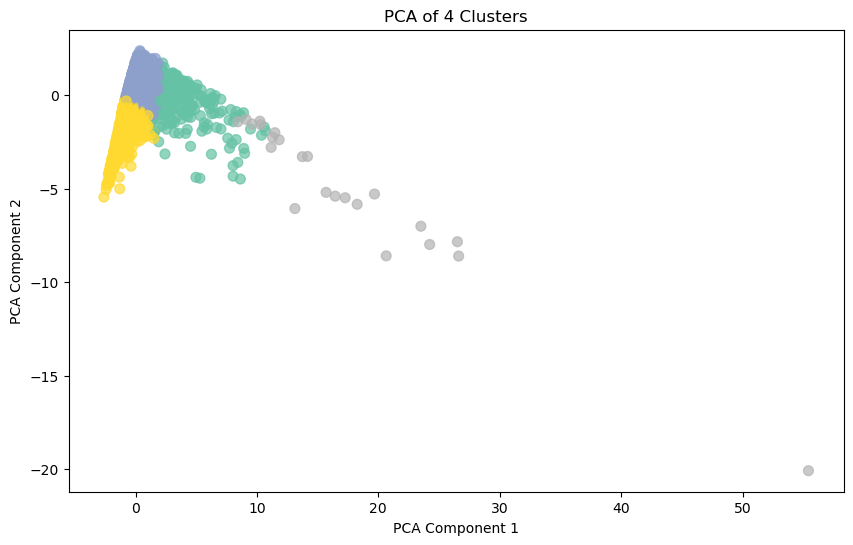

In [439]:
print("Best Parameters for K-Means:")
print(
    "Number of Clusters:", bayes_search.best_params_['n_clusters'],
    "\nInitialization Method:", bayes_search.best_params_['init'],
    "\nNumber of Initializations:", bayes_search.best_params_['n_init'],
    "\nMaximum Number of Iterations:", bayes_search.best_params_['max_iter']
)
plot_PCA_clusters(data_transformed, y_pred, bayes_search.best_params_['n_clusters'])

**K-Means Clustering on Numerical Data**

K-Means clustering is a distance-based algorithm that relies on calculating Euclidean distances to form clusters. Since numerical features are continuous and naturally suited to distance calculations, they provide a clear and interpretable structure for clustering. By focusing on numerical data, we ensure that the clusters formed are mathematically meaningful and reflect the inherent relationships in the data. This approach also helps us isolate the impact of quantitative variables on the clustering results, leading to more accurate and insightful analysis.

In this section, we apply K-Means clustering exclusively on the numerical features of the dataset. This allows us to assess how well the numerical data alone can group the video games into meaningful clusters.


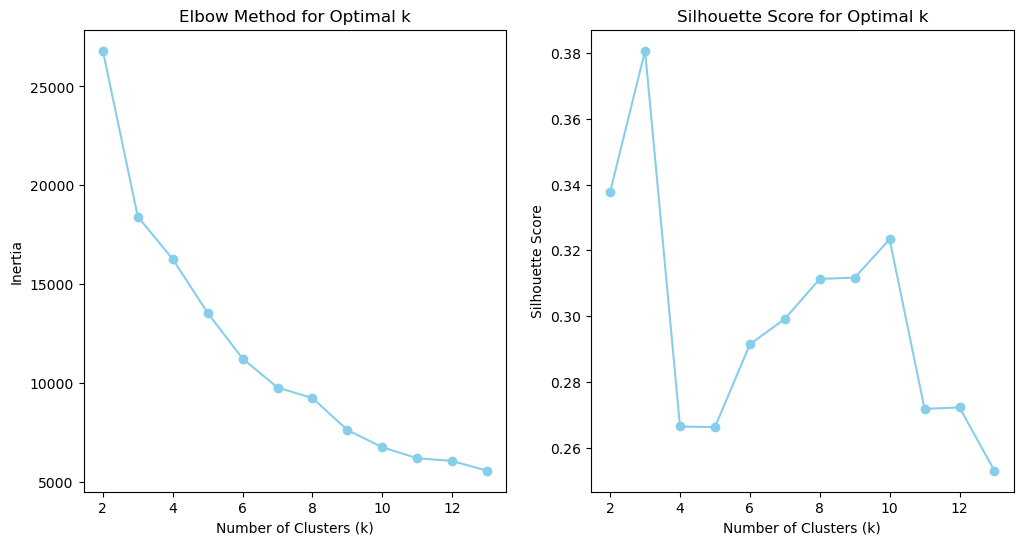

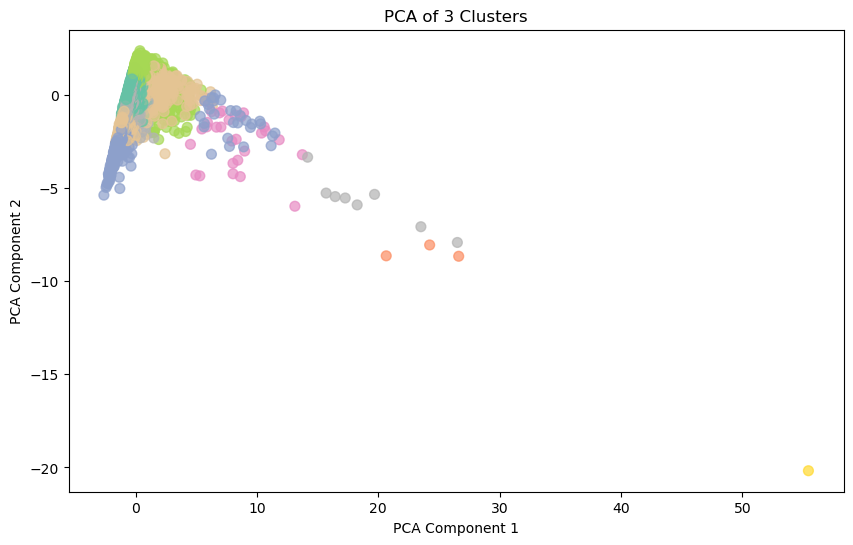

In [440]:
# kmeans of only numerical data
numerical_data = data_cleaned[features_kept].select_dtypes(include=['int64', 'float64'])
numerical_data_transformed = StandardScaler().fit_transform(numerical_data)

inertia = []
silhouette_scores = []
k_range = range(2, 14)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(numerical_data_transformed)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(numerical_data_transformed, kmeans.labels_))


plot_inertia_silhouette(inertia, silhouette_scores, k_range)

optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
kmeans_labels = kmeans.fit_predict(numerical_data_transformed)
plot_PCA_clusters(numerical_data_transformed, kmeans_labels, optimal_k)

In [441]:
# Separate numerical and categorical features
print("number of clusters: ", data_with_clusters['Cluster'].nunique())



cluster_ids = []
avg_critic_scores = []
avg_user_scores = []
avg_na_eu_sales = []
avg_jp_sales = []
avg_global_sales = []
top_genres_list = []
top_year_categories_list = []

# Calculate the required statistics for each cluster
for cluster in range(data_with_clusters['Cluster'].nunique()):
    # Filter the data for the current cluster
    cluster_data = data_with_clusters[data_with_clusters['Cluster'] == cluster]
    
    # Append cluster id
    cluster_ids.append(cluster)

    # 1. Average Critic Score and Average User Score
    avg_critic_scores.append(cluster_data['Critic_Score'].mean())
    avg_user_scores.append(cluster_data['User_Score'].mean())
    
    # 2. Average Sales in Each Region
    avg_na_eu_sales.append(cluster_data['NA_EU_Sales'].mean())
    avg_jp_sales.append(cluster_data['JP_Sales'].mean())
    avg_global_sales.append(cluster_data['Global_Sales'].mean())
    
    # 3. Top 5 Frequent Genres
    top_genres = cluster_data['Genre'].value_counts().head(5).index.tolist()
    top_genres_list.append(", ".join(top_genres))
    
    # 4. Top 5 Year Categories
    top_year_categories = cluster_data['Year_Category'].value_counts().head(5).index.tolist()
    top_year_categories_list.append(", ".join(top_year_categories))

# Create a DataFrame to hold the cluster summary
cluster_summary_df = pd.DataFrame({
    'Cluster': cluster_ids,
    'Avg Critic Score': avg_critic_scores,
    'Avg User Score': avg_user_scores,
    'Avg NA/EU Sales': avg_na_eu_sales,
    'Avg JP Sales': avg_jp_sales,
    'Avg Global Sales': avg_global_sales,
    'Top 5 Genres': top_genres_list,
    'Top 5 Year Categories': top_year_categories_list
})

# Display the DataFrame
cluster_summary_df

number of clusters:  4


,Cluster,Avg Critic Score,Avg User Score,Avg NA/EU Sales,Avg JP Sales,Avg Global Sales,Top 5 Genres,Top 5 Year Categories
0,0,84.879310,7.818678,3.891552,0.461293,4.922241,"Action, Shooter, Role-Playing, Sports, Misc","2000s, 2010s, 1990s"
1,1,75.646248,7.817349,0.454693,0.037366,0.548709,"Action, Sports, Shooter, Role-Playing, Racing","2000s, 2010s, 1990s"
2,2,54.361126,5.523101,0.270961,0.013675,0.318933,"Action, Shooter, Sports, Racing, Misc","2000s, 2010s, 1990s, Before 1990"
3,3,83.826087,8.169565,15.686087,3.513043,21.104783,"Racing, Sports, Role-Playing, Misc, Platform","2000s, 2010s, 1990s"


### **5. Conclusion**

In this project, we applied unsupervised learning techniques, specifically K-Means clustering, to analyze a dataset of video game sales and ratings. The goal was to identify meaningful clusters within the data that could provide insights into factors contributing to high sales and potentially aid in developing a recommender system for similar games.

Through careful data preprocessing, including handling missing values, feature engineering, and scaling, we prepared the dataset for clustering analysis. We used various metrics, such as Inertia and Silhouette Scores, to determine the optimal number of clusters and employed Principal Component Analysis (PCA) to visualize the resulting clusters in a reduced-dimensional space.

Additionally, we performed Bayesian Optimization to fine-tune the K-Means hyperparameters, ensuring the most accurate and effective clustering possible. The final clusters were analyzed by examining average critic and user scores, average sales in different regions, and the most frequent genres, year categories, and developers in each cluster.

**Key Findings:**


- **Cluster Characteristics:** The clusters identified varied significantly in terms of average sales, critic scores, and user scores. This suggests that different groups of games are driven by different factors, such as critical acclaim or regional popularity.


- **Genre and Platform Trends:** Certain genres and platforms were more prevalent in specific clusters, indicating that some combinations are more successful or popular than others.


- **Decade Influence:** The release decade also played a significant role in clustering, with older and newer games often forming distinct groups.

**Drawbacks and Limitations:**


- **Model Sophistication:** While K-Means clustering provides a basic understanding of the data, it may not be sophisticated enough for a fully functional recommendation system. The clusters identified might oversimplify the complexities of user preferences and game features.


- **Limitations with Categorical Features:** The K-Means algorithm is inherently better suited for numerical data. As a result, it may not effectively distinguish between genres or other categorical features, which could lead to less precise clustering outcomes. This limitation suggests that a more nuanced approach or a different algorithm may be necessary to fully capture the distinctions among categorical data.

**Applications and Future Work:**


- **Recommender Systems:** The insights gained from clustering can be used to develop more targeted recommender systems that suggest games to users based on similar titles in their preferred clusters. However, further refinement and integration with more sophisticated models would be necessary for a fully operational system.

- **Market Strategy:** Game developers and publishers can leverage the cluster characteristics to understand market trends better and tailor their strategies to target specific clusters with high sales potential.

This project demonstrates the power of clustering in uncovering hidden patterns within complex datasets, offering valuable insights that can inform decision-making and strategic planning in the video game industry. Future work could involve exploring other clustering algorithms, such as hierarchical clustering, or integrating external data sources to further refine and enhance the clustering results. Additionally, addressing the limitations related to categorical features and model complexity will be crucial for improving the overall effectiveness of the clustering approach.
